# Stock Market Data Analysis using ARIMA and LSTM

This notebook demonstrates a complete workflow for analyzing and forecasting stock prices using both classical time series methods (ARIMA) and a deep learning approach (LSTM). The analysis covers data collection, exploratory time series analysis, model building, forecasting, and performance comparison.

In [1]:
# Stock Market Data Analysis using ARIMA and LSTM

# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical libraries for time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Deep learning libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. Data Collection and Preparation

This section focuses on downloading historical stock data using the `yfinance` library and performing initial data inspection and preparation steps.

In [2]:
# 1. DATA COLLECTION AND PREPARATION

def download_stock_data(ticker="AAPL", period="5y"):
    """
    Download stock data from Yahoo Finance

    Parameters:
    ticker (str): Stock ticker symbol
    period (str): Time period for data ('1y', '2y', '5y', etc.)

    Returns:
    pandas.DataFrame: Stock data with OHLCV information
    """
    try:
        stock = yf.Ticker(ticker)
        data = stock.history(period=period)
        print(f"Successfully downloaded {len(data)} days of data for {ticker}")
        print(f"Date range: {data.index[0].date()} to {data.index[-1].date()}")
        return data
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None

In [3]:
# Download Apple stock data
TICKER = "AAPL"
stock_data = download_stock_data(TICKER, "5y")

Successfully downloaded 1256 days of data for AAPL
Date range: 2020-07-27 to 2025-07-25


In [4]:
# Display basic information about the dataset
print("\nDataset Info:")
print(f"Shape: {stock_data.shape}")
print(f"Columns: {list(stock_data.columns)}")
print("\nFirst 5 rows:")
print(stock_data.head())
print("\nLast 5 rows:")
print(stock_data.tail())


Dataset Info:
Shape: (1256, 7)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']

First 5 rows:
                                 Open        High        Low       Close  \
Date                                                                       
2020-07-27 00:00:00-04:00   91.092598   92.254221  90.869027   92.161873   
2020-07-28 00:00:00-04:00   91.731743   91.909149  90.643023   90.647888   
2020-07-29 00:00:00-04:00   91.131475   92.570140  91.095024   92.385445   
2020-07-30 00:00:00-04:00   91.556748   93.607814  91.148481   93.503319   
2020-07-31 00:00:00-04:00  100.011320  103.442723  98.008853  103.292053   

                              Volume  Dividends  Stock Splits  
Date                                                           
2020-07-27 00:00:00-04:00  121214000        0.0           0.0  
2020-07-28 00:00:00-04:00  103625600        0.0           0.0  
2020-07-29 00:00:00-04:00   90329200        0.0           0.0  
2020-07-30 00:00:00

## 2. Time Series Analysis

Here, we explore the characteristics of the stock price data through various time series analysis techniques, including plotting the price over time, calculating moving averages, performing seasonal decomposition, and analyzing autocorrelation and partial autocorrelation to understand the data's structure and stationarity.

In [5]:
# 2. TIME SERIES ANALYSIS

def plot_stock_price(data, ticker):
    """Plot the closing price over time"""
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], linewidth=1, alpha=0.8)
    plt.title(f'{ticker} Stock Close Price Over Time', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close Price ($)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

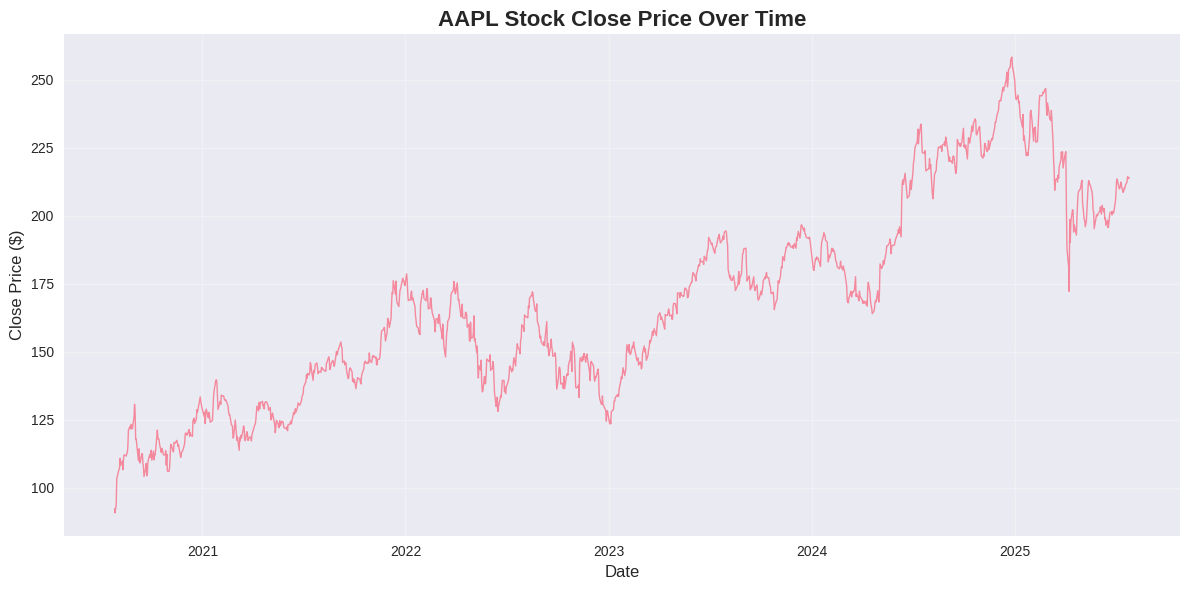

In [6]:
# Plot the closing price
plot_stock_price(stock_data, TICKER)

In [7]:
def calculate_moving_averages(data):
    """Calculate rolling moving averages"""
    data['MA_7'] = data['Close'].rolling(window=7).mean()
    data['MA_30'] = data['Close'].rolling(window=30).mean()
    return data

# Calculate moving averages
stock_data = calculate_moving_averages(stock_data)

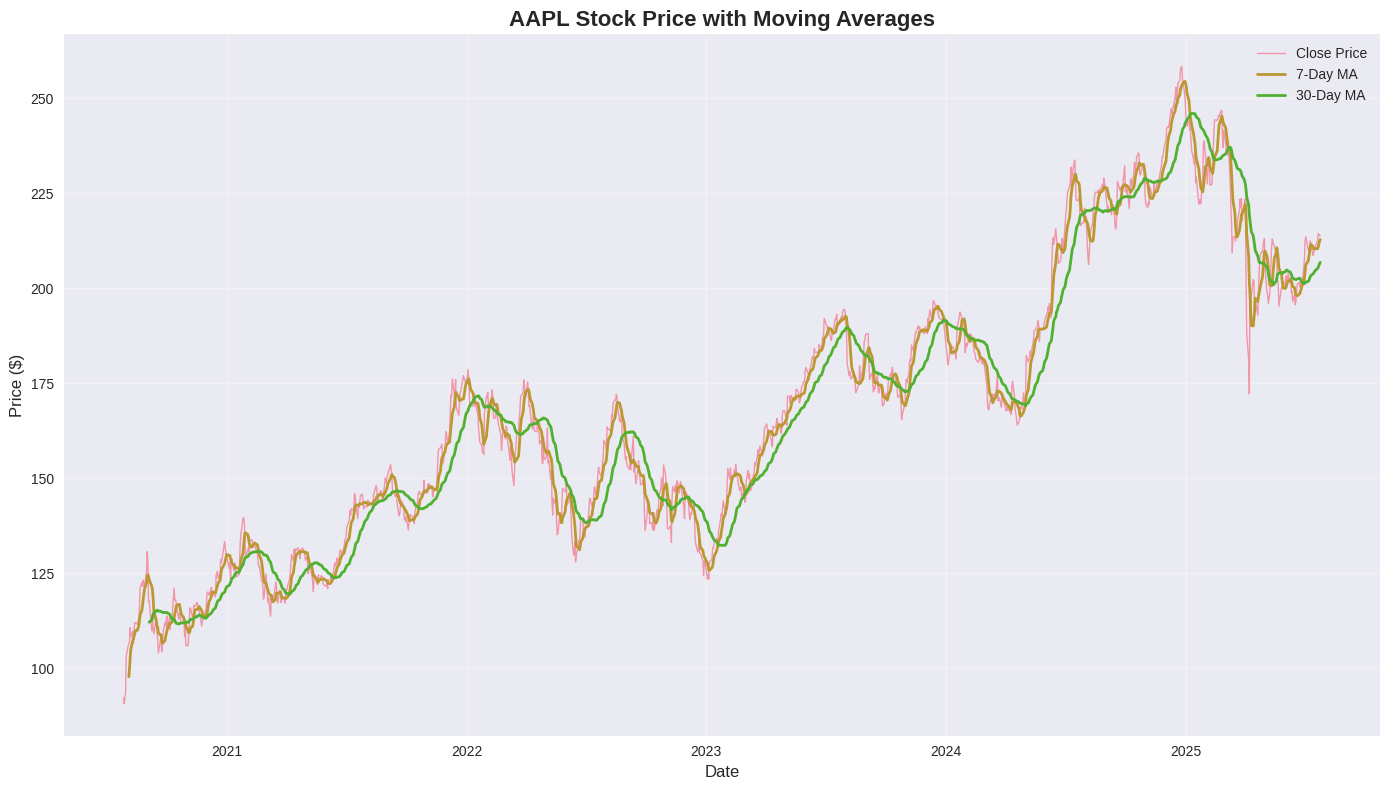

In [8]:
def plot_moving_averages(data, ticker):
    """Plot closing price with moving averages"""
    plt.figure(figsize=(14, 8))
    plt.plot(data.index, data['Close'], label='Close Price', linewidth=1, alpha=0.7)
    plt.plot(data.index, data['MA_7'], label='7-Day MA', linewidth=2)
    plt.plot(data.index, data['MA_30'], label='30-Day MA', linewidth=2)
    plt.title(f'{ticker} Stock Price with Moving Averages', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot moving averages
plot_moving_averages(stock_data, TICKER)

In [11]:
def seasonal_decomposition_analysis(data, ticker):
    """Perform seasonal decomposition"""
    # Use Close price for decomposition
    close_prices = data['Close'].dropna()

    # Perform seasonal decomposition
    decomposition = seasonal_decompose(close_prices, model='multiplicative', period=252)  # 252 trading days in a year

    # Plot decomposition
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))

    decomposition.observed.plot(ax=axes[0], title=f'{ticker} - Original Time Series')
    decomposition.trend.plot(ax=axes[1], title='Trend Component')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
    decomposition.resid.plot(ax=axes[3], title='Residual Component')

    plt.tight_layout()
    plt.show()

    return decomposition

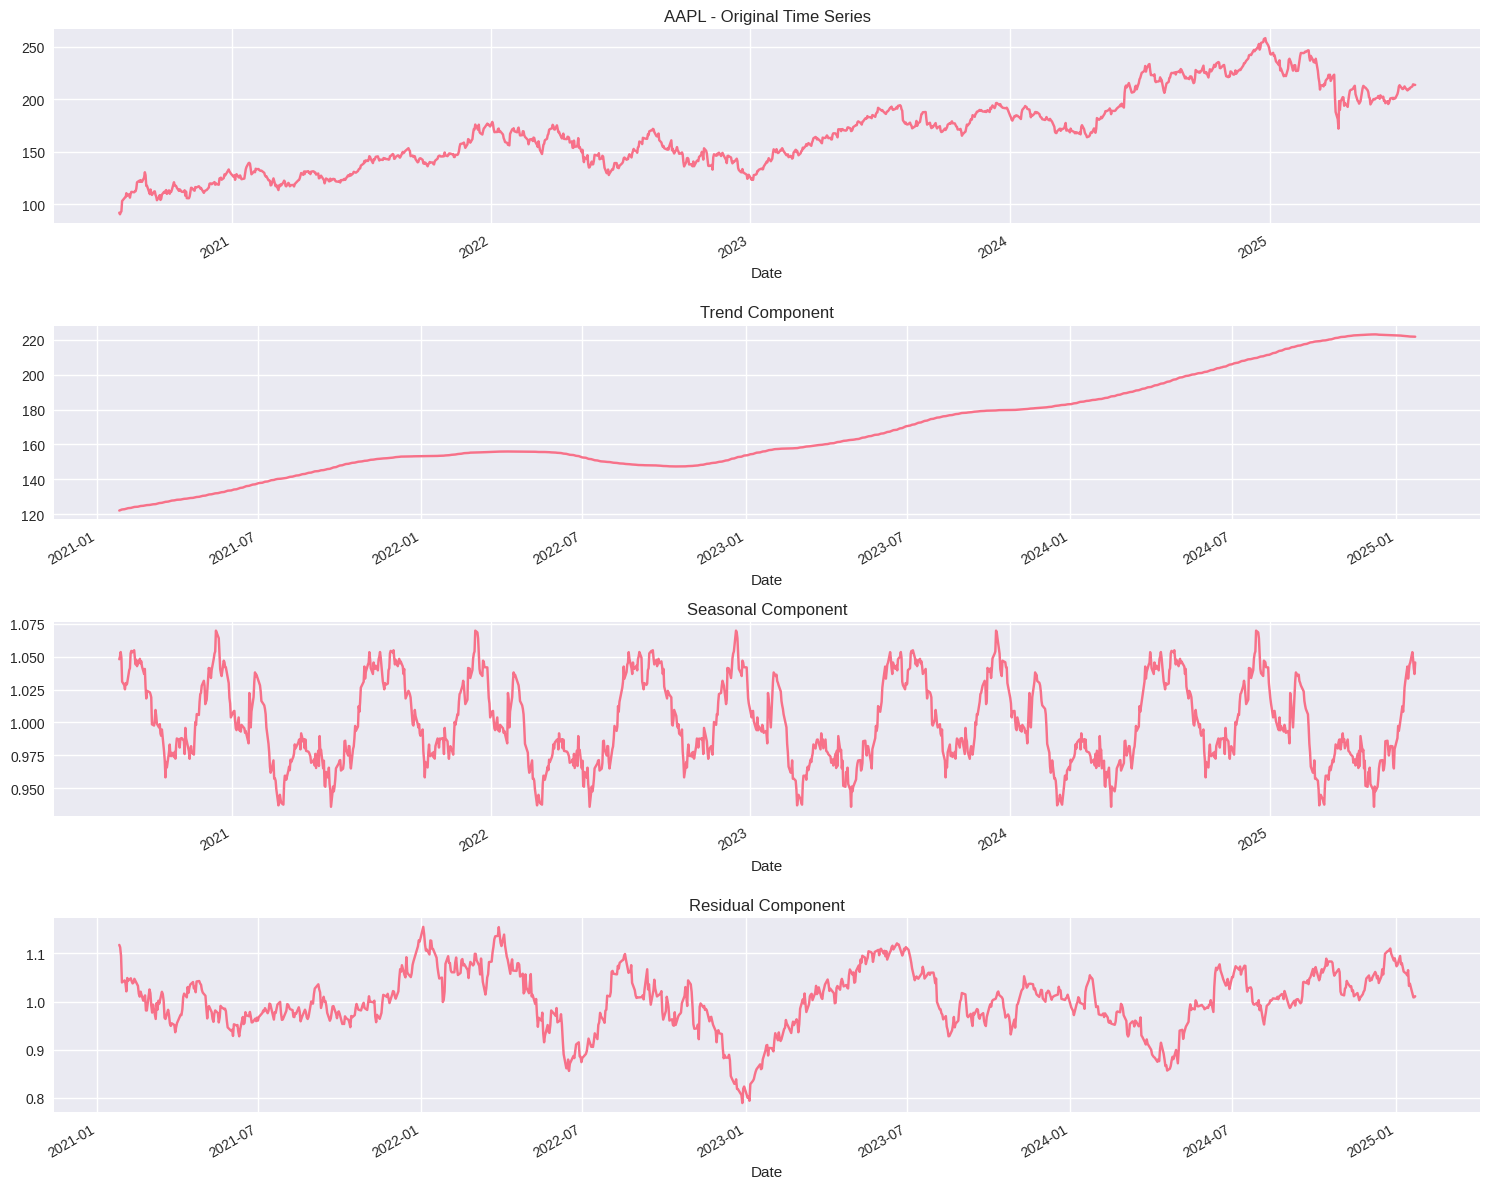

In [12]:
# Perform seasonal decomposition
decomposition = seasonal_decomposition_analysis(stock_data, TICKER)

In [13]:
def check_stationarity(timeseries, title):
    """
    Check stationarity using Augmented Dickey-Fuller test
    """
    print(f'Results of Augmented Dickey-Fuller Test for {title}:')
    dftest = adfuller(timeseries.dropna())
    dfoutput = pd.Series(dftest[0:4], index=['ADF Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

    if dftest[1] <= 0.05:
        print("Series is stationary (reject null hypothesis)")
    else:
        print("Series is not stationary (fail to reject null hypothesis)")
    print("-" * 50)

# Check stationarity of original series
check_stationarity(stock_data['Close'], f'{TICKER} Close Price')

Results of Augmented Dickey-Fuller Test for AAPL Close Price:
ADF Statistic                    -1.934925
p-value                           0.315814
#Lags Used                        0.000000
Number of Observations Used    1255.000000
Critical Value (1%)              -3.435571
Critical Value (5%)              -2.863846
Critical Value (10%)             -2.567998
dtype: float64
Series is not stationary (fail to reject null hypothesis)
--------------------------------------------------


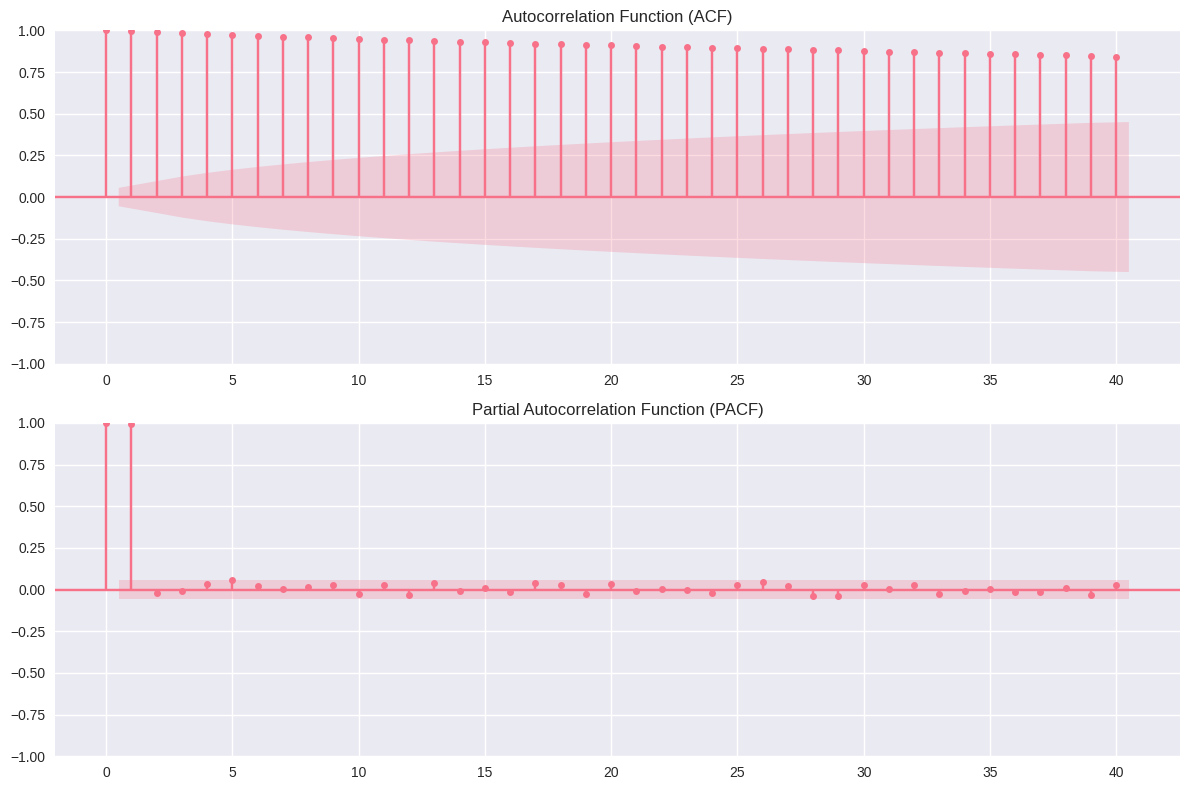

In [14]:
def plot_acf_pacf(data, lags=40):
    """Plot ACF and PACF"""
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    plot_acf(data.dropna(), lags=lags, ax=axes[0], title='Autocorrelation Function (ACF)')
    plot_pacf(data.dropna(), lags=lags, ax=axes[1], title='Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()

# Plot ACF and PACF for original series
plot_acf_pacf(stock_data['Close'])

In [15]:
# Apply differencing if series is not stationary
stock_data['Close_diff'] = stock_data['Close'].diff()

In [16]:
# Check stationarity after differencing
check_stationarity(stock_data['Close_diff'], f'{TICKER} Close Price (First Difference)')


Results of Augmented Dickey-Fuller Test for AAPL Close Price (First Difference):
ADF Statistic                   -21.081593
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    1252.000000
Critical Value (1%)              -3.435584
Critical Value (5%)              -2.863851
Critical Value (10%)             -2.568001
dtype: float64
Series is stationary (reject null hypothesis)
--------------------------------------------------


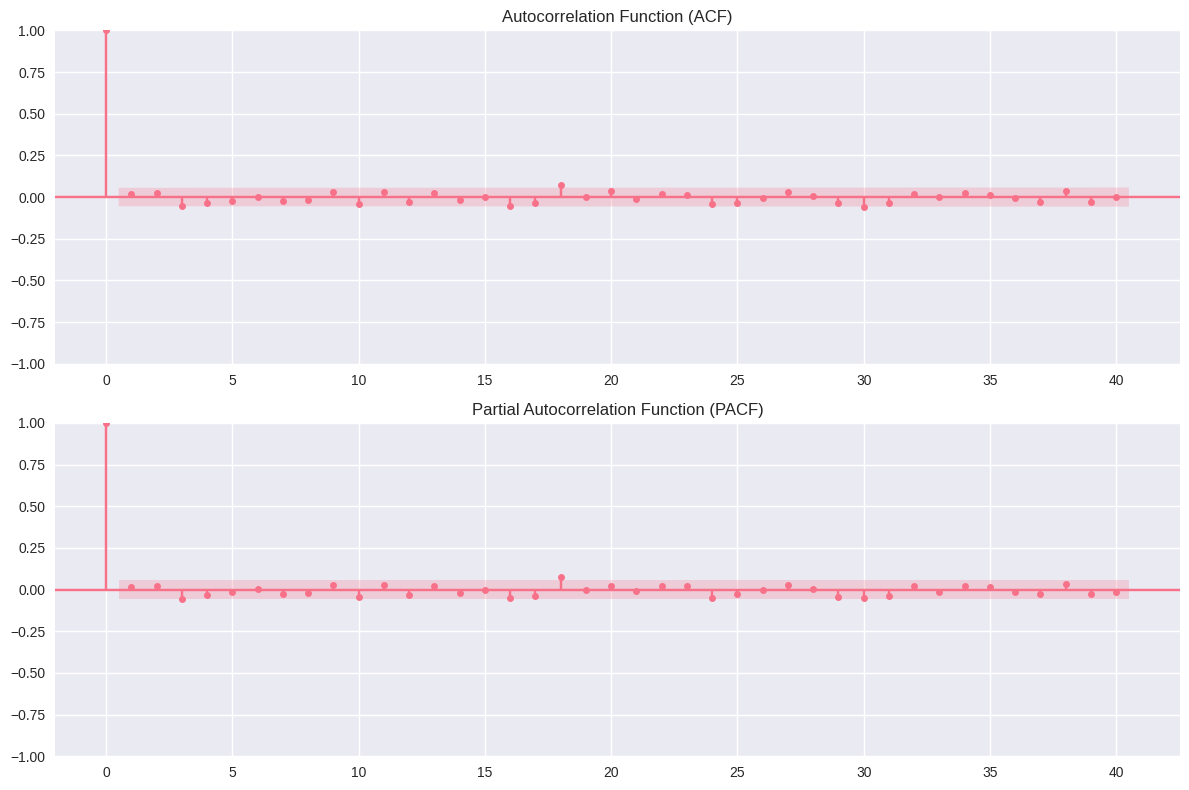

In [17]:
# Plot ACF and PACF for differenced series
plot_acf_pacf(stock_data['Close_diff'])

## 3. ARIMA Benchmark Model

This section builds and evaluates a classical ARIMA model as a benchmark for stock price forecasting. It involves finding the optimal ARIMA order using the AIC criterion, fitting the model to the training data, generating forecasts, and assessing performance using MAE and RMSE.

In [18]:
# 3. ARIMA BENCHMARK MODEL

def find_best_arima_order(data, max_p=5, max_d=2, max_q=5):
    """
    Find best ARIMA order using AIC criterion
    """
    best_aic = float('inf')
    best_params = None
    results_table = []

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(data, order=(p, d, q))
                    fitted_model = model.fit()
                    aic = fitted_model.aic
                    results_table.append([p, d, q, aic])

                    if aic < best_aic:
                        best_aic = aic
                        best_params = (p, d, q)

                except Exception as e:
                    continue

    results_df = pd.DataFrame(results_table, columns=['p', 'd', 'q', 'AIC'])
    results_df = results_df.sort_values('AIC').reset_index(drop=True)

    print("Top 10 ARIMA models by AIC:")
    print(results_df.head(10))
    print(f"\nBest ARIMA order: {best_params} with AIC: {best_aic:.2f}")

    return best_params, results_df

In [25]:
# Find best ARIMA parameters
# Using a subset of data for faster computation
train_data = stock_data['Close'][:-30]  # Keep last 30 days for testing
# Explicitly set the frequency of the time series data to daily ('D') and fill missing values
train_data = train_data.asfreq('D').ffill()
best_order, arima_results = find_best_arima_order(train_data, max_p=3, max_d=2, max_q=3)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Top 10 ARIMA models by AIC:
   p  d  q          AIC
0  0  1  0  8375.566318
1  0  1  1  8377.547263
2  1  1  0  8377.547459
3  1  1  1  8377.972670
4  2  1  0  8379.500511
5  0  1  2  8379.500802
6  2  1  1  8379.948387
7  0  2  1  8380.393305
8  3  1  3  8380.947987
9  2  2  3  8381.302623

Best ARIMA order: (0, 1, 0) with AIC: 8375.57


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
def fit_arima_model(data, order):
    """Fit ARIMA model and generate forecasts"""
    model = ARIMA(data, order=order)
    fitted_model = model.fit()

    print("ARIMA Model Summary:")
    print(fitted_model.summary())

    return fitted_model

# Fit the best ARIMA model
arima_model = fit_arima_model(train_data, best_order)

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1781
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4186.783
Date:                Sat, 26 Jul 2025   AIC                           8375.566
Time:                        15:27:22   BIC                           8381.051
Sample:                    07-27-2020   HQIC                          8377.592
                         - 06-11-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         6.4648      0.081     79.454      0.000       6.305       6.624
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             11019.46
Prob(Q):                  

In [36]:
# Fit the best ARIMA model
arima_model = fit_arima_model(train_data, best_order)

def forecast_arima(model, start_date, end_date):
    """Generate ARIMA forecasts for a specified date range"""
    forecast = model.predict(start=start_date, end=end_date)
    forecast_ci = model.predict(start=start_date, end=end_date, return_conf_int=True)[1]

    return forecast, forecast_ci

# Generate ARIMA forecasts using the test data index
arima_forecast, arima_ci = forecast_arima(arima_model, test_data.index[0], test_data.index[-1])

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1781
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4186.783
Date:                Sat, 26 Jul 2025   AIC                           8375.566
Time:                        15:33:42   BIC                           8381.051
Sample:                    07-27-2020   HQIC                          8377.592
                         - 06-11-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         6.4648      0.081     79.454      0.000       6.305       6.624
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             11019.46
Prob(Q):                  

In [43]:
# Generate ARIMA forecasts using the test data index
arima_forecast, arima_ci = forecast_arima(arima_model, test_data.index[0], test_data.index[-1])

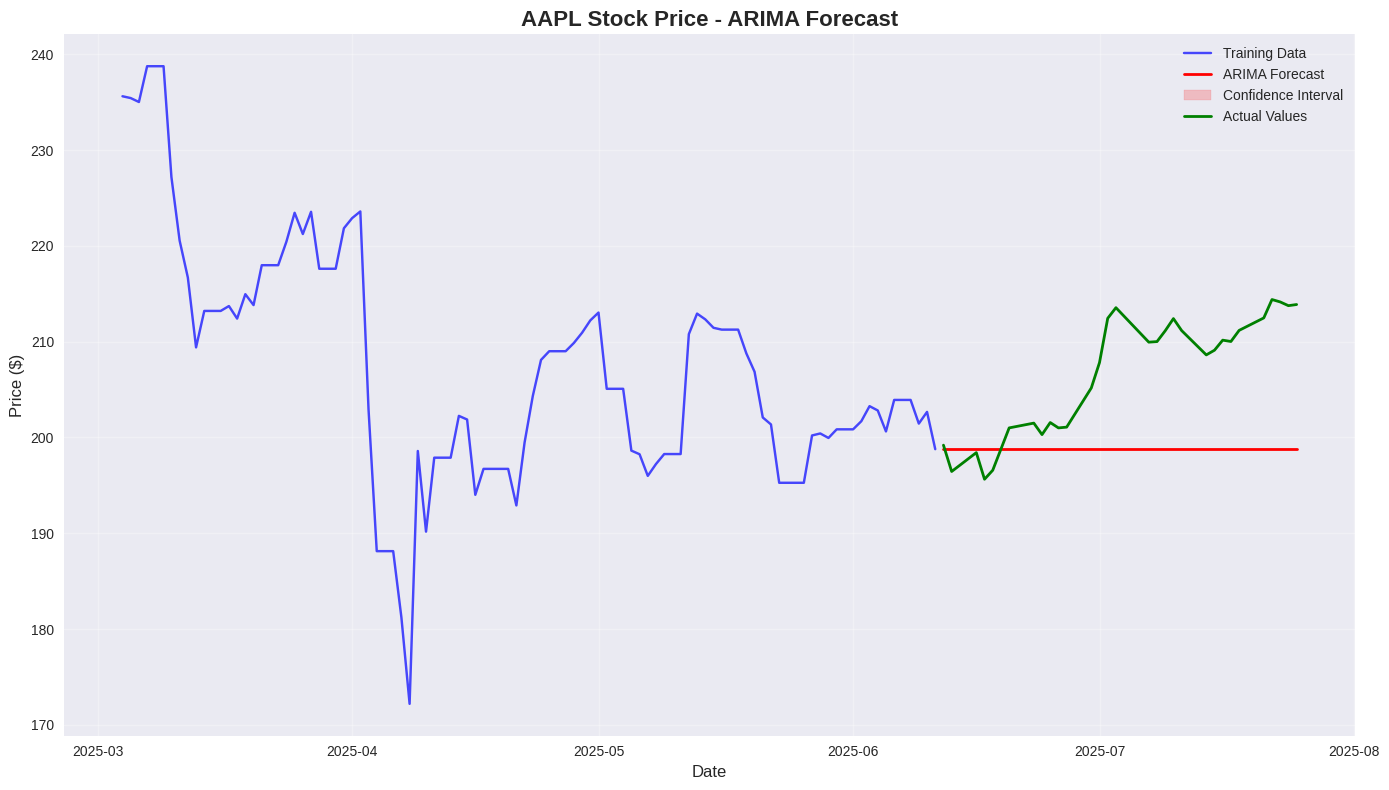

In [44]:
def plot_arima_forecast(data, forecast, confidence_intervals, test_data=None):
    """Plot ARIMA forecast results"""
    plt.figure(figsize=(14, 8))

    # Plot training data
    plt.plot(data.index[-100:], data.iloc[-100:], label='Training Data', color='blue', alpha=0.7)

    # Create a DataFrame for confidence intervals with the forecast index
    confidence_intervals_df = pd.DataFrame(confidence_intervals, index=forecast.index, columns=['lower', 'upper'])

    # Plot forecast
    plt.plot(forecast.index, forecast, label='ARIMA Forecast', color='red', linewidth=2)
    plt.fill_between(confidence_intervals_df.index,
                     confidence_intervals_df['lower'],
                     confidence_intervals_df['upper'],
                     color='red', alpha=0.2, label='Confidence Interval')

    # Plot test data if available
    if test_data is not None:
        plt.plot(test_data.index, test_data,
                label='Actual Values', color='green', linewidth=2)

    plt.title(f'{TICKER} Stock Price - ARIMA Forecast', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot ARIMA results
test_data = stock_data['Close'][-30:]
arima_forecast, arima_ci = forecast_arima(arima_model, test_data.index[0], test_data.index[-1]) # Regenerate forecast with correct dates
plot_arima_forecast(train_data, arima_forecast, arima_ci, test_data)

In [45]:
# Calculate ARIMA performance metrics
def calculate_metrics(actual, predicted):
    """Calculate MAE and RMSE"""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    return mae, rmse

# Align forecast with actual test data
min_len = min(len(test_data), len(arima_forecast))
arima_mae, arima_rmse = calculate_metrics(test_data.iloc[:min_len], arima_forecast[:min_len])

print(f"\nARIMA Model Performance:")
print(f"MAE: ${arima_mae:.2f}")
print(f"RMSE: ${arima_rmse:.2f}")
print(f"Chosen ARIMA order: {best_order}")
print(f"Reasoning: Selected based on lowest AIC value from grid search")


ARIMA Model Performance:
MAE: $8.56
RMSE: $10.09
Chosen ARIMA order: (0, 1, 0)
Reasoning: Selected based on lowest AIC value from grid search


## 4. LSTM Deep Learning Model

This part implements a deep learning approach using a Long Short-Term Memory (LSTM) network for stock price prediction. It includes preparing the data using a sliding window, scaling the data, building and training the LSTM model, generating predictions, and evaluating its performance.

In [46]:
# 4. LSTM DEEP LEARNING MODEL

def prepare_lstm_data(data, lookback_window=60):
    """
    Prepare data for LSTM model using sliding window approach
    """
    # Use only Close prices
    prices = data['Close'].values.reshape(-1, 1)

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = scaler.fit_transform(prices)

    # Create sliding windows
    X, y = [], []
    for i in range(lookback_window, len(scaled_prices)):
        X.append(scaled_prices[i-lookback_window:i, 0])
        y.append(scaled_prices[i, 0])

    X, y = np.array(X), np.array(y)

    # Split into train and test sets
    split_idx = len(X) - 30  # Last 30 days for testing
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Reshape for LSTM (samples, time steps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    return X_train, X_test, y_train, y_test, scaler

# Prepare LSTM data
X_train, X_test, y_train, y_test, scaler = prepare_lstm_data(stock_data)

print(f"LSTM Data Preparation:")
print(f"Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

LSTM Data Preparation:
Training set shape: X_train: (1166, 60, 1), y_train: (1166,)
Test set shape: X_test: (30, 60, 1), y_test: (30,)


In [47]:
def build_lstm_model(input_shape):
    """
    Build LSTM model architecture
    """
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Build LSTM model
lstm_model = build_lstm_model((X_train.shape[1], 1))
print("\nLSTM Model Architecture:")
lstm_model.summary()


LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
def train_lstm_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    """
    Train LSTM model
    """
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_test, y_test),
        verbose=1,
        shuffle=False
    )
    return history

# Train LSTM model
print("\nTraining LSTM model...")
lstm_history = train_lstm_model(lstm_model, X_train, y_train, X_test, y_test, epochs=50)



Training LSTM model...
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0128 - mae: 0.0937 - val_loss: 0.0093 - val_mae: 0.0913
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0140 - mae: 0.0963 - val_loss: 0.0044 - val_mae: 0.0587
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0290 - mae: 0.1430 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0261 - mae: 0.1368 - val_loss: 0.0015 - val_mae: 0.0284
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0281 - mae: 0.1409 - val_loss: 0.0011 - val_mae: 0.0300
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0291 - mae: 0.1429 - val_loss: 0.0212 - val_mae: 0.1421
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0500 - mae: 0.1827 - val_loss: 0.0441 - val_mae: 0.2074
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0641 - mae: 0.2037 - val_loss: 0.0267 - val_mae: 0.1606
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s

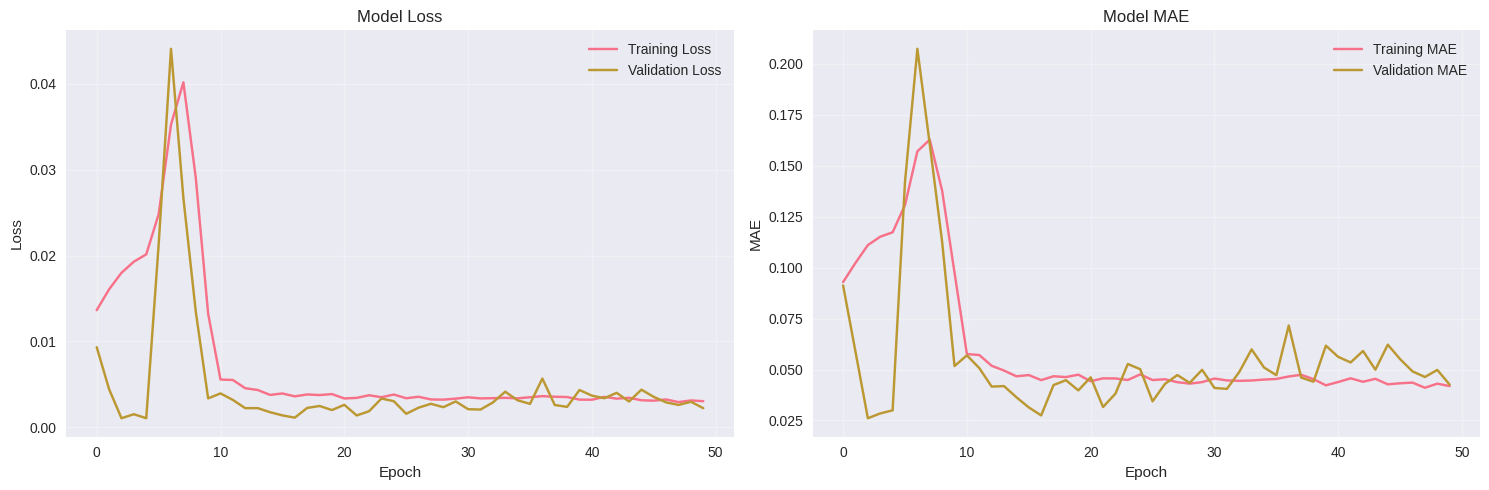

In [49]:
def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot MAE
    ax2.plot(history.history['mae'], label='Training MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title('Model MAE')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(lstm_history)

In [50]:
def make_lstm_predictions(model, X_test, scaler):
    """Generate LSTM predictions"""
    predictions_scaled = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions_scaled)
    return predictions.flatten()

# Generate LSTM predictions
lstm_predictions = make_lstm_predictions(lstm_model, X_test, scaler)

# Transform actual test values back to original scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


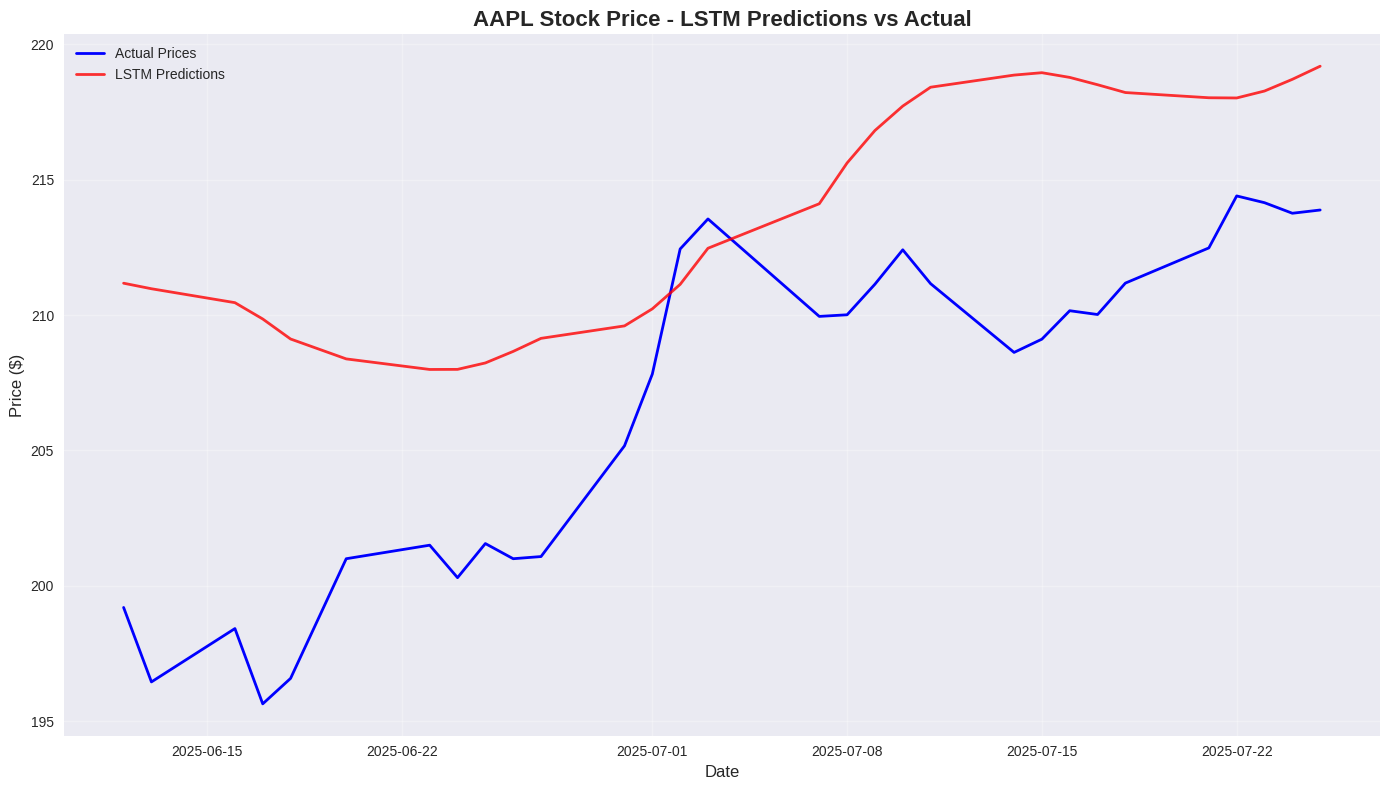


LSTM Model Performance:
MAE: $7.14
RMSE: $7.92


In [51]:
def plot_lstm_predictions(actual, predicted, ticker):
    """Plot LSTM predictions vs actual values"""
    plt.figure(figsize=(14, 8))

    dates = stock_data.index[-len(actual):]
    plt.plot(dates, actual, label='Actual Prices', color='blue', linewidth=2)
    plt.plot(dates, predicted, label='LSTM Predictions', color='red', linewidth=2, alpha=0.8)

    plt.title(f'{ticker} Stock Price - LSTM Predictions vs Actual', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot LSTM predictions
plot_lstm_predictions(y_test_actual, lstm_predictions, TICKER)

# Calculate LSTM performance metrics
lstm_mae, lstm_rmse = calculate_metrics(y_test_actual, lstm_predictions)

print(f"\nLSTM Model Performance:")
print(f"MAE: ${lstm_mae:.2f}")
print(f"RMSE: ${lstm_rmse:.2f}")


## 5. Model Comparison

In this section, we visually compare the forecasts generated by the ARIMA and LSTM models against the actual stock prices. We also present a quantitative comparison of their performance metrics (MAE and RMSE).

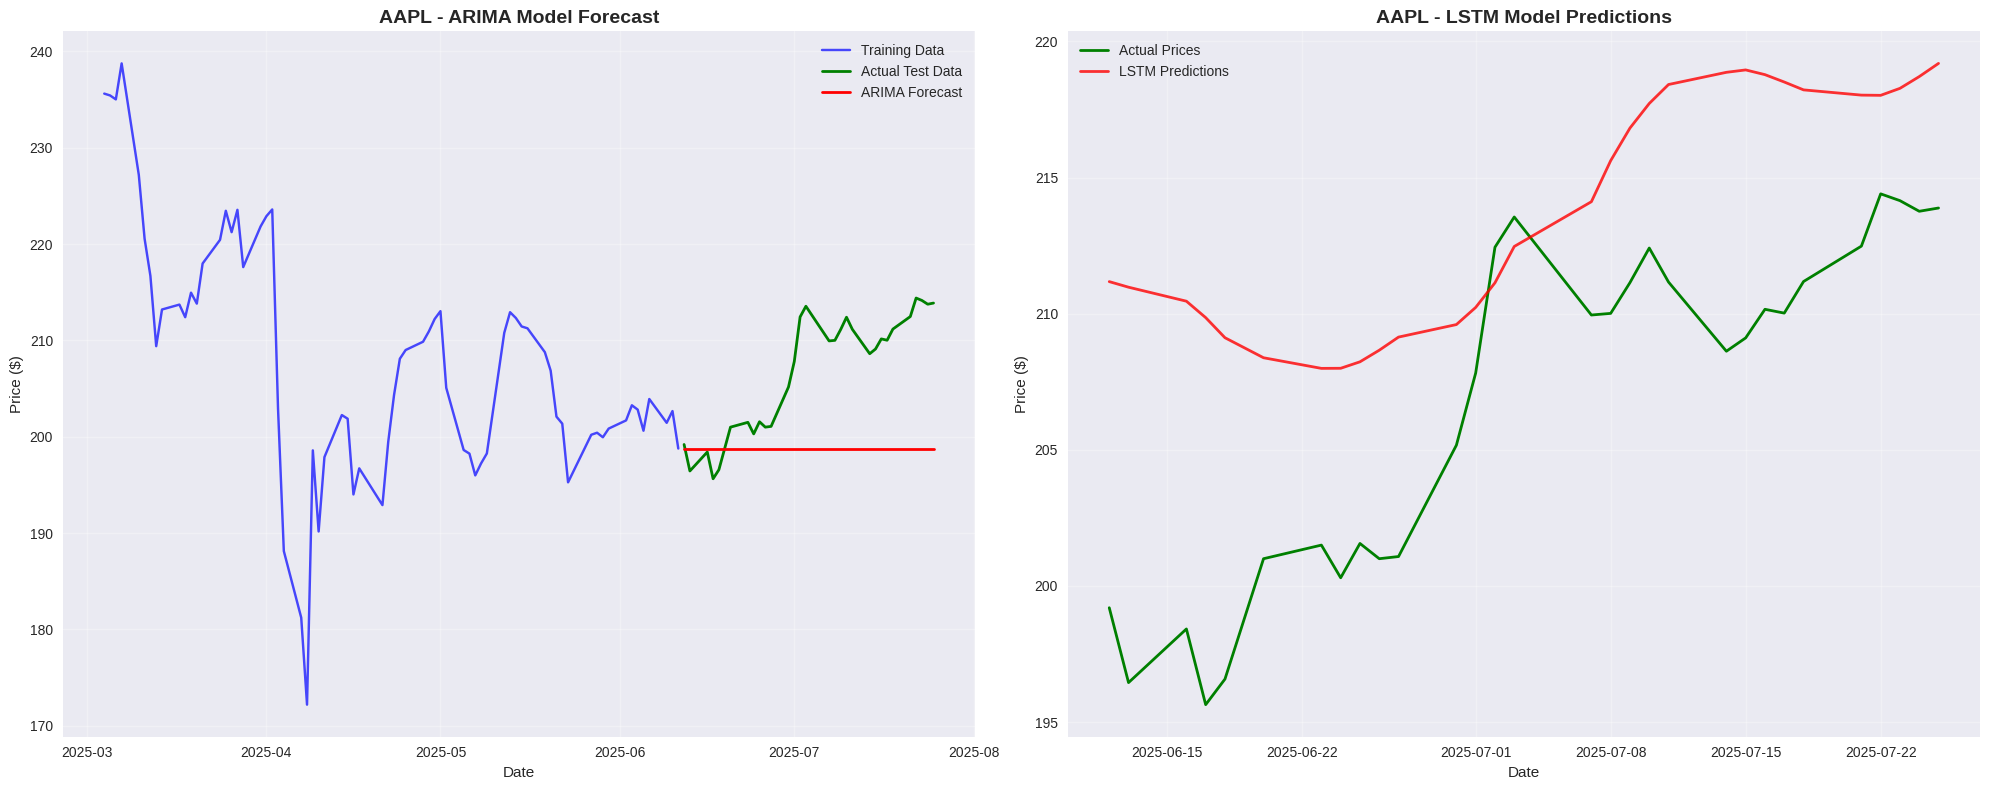


Model Performance Comparison:
Model  MAE  RMSE
ARIMA 8.56 10.09
 LSTM 7.14  7.92

Performance Improvement (LSTM vs ARIMA):
MAE Improvement: 16.6%
RMSE Improvement: 21.5%


In [53]:
def plot_model_comparison(actual_data, arima_forecast, lstm_predictions, ticker):
    """
    Create side-by-side comparison of ARIMA and LSTM forecasts
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # ARIMA Plot
    train_data_plot = stock_data['Close'][-100:-30]
    test_dates = actual_data.index[:len(arima_forecast)]

    ax1.plot(train_data_plot.index, train_data_plot.values, label='Training Data', color='blue', alpha=0.7)
    ax1.plot(test_dates, actual_data.iloc[:len(arima_forecast)], label='Actual Test Data', color='green', linewidth=2)
    ax1.plot(test_dates, arima_forecast[:len(test_dates)], label='ARIMA Forecast', color='red', linewidth=2)
    ax1.set_title(f'{ticker} - ARIMA Model Forecast', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # LSTM Plot
    lstm_dates = stock_data.index[-len(lstm_predictions):]
    ax2.plot(lstm_dates, y_test_actual, label='Actual Prices', color='green', linewidth=2)
    ax2.plot(lstm_dates, lstm_predictions, label='LSTM Predictions', color='red', linewidth=2, alpha=0.8)
    ax2.set_title(f'{ticker} - LSTM Model Predictions', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price ($)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Create comparison plot
plot_model_comparison(test_data, arima_forecast, lstm_predictions, TICKER)

# Performance comparison
def create_performance_comparison():
    """Create a performance comparison table"""
    comparison_df = pd.DataFrame({
        'Model': ['ARIMA', 'LSTM'],
        'MAE': [arima_mae, lstm_mae],
        'RMSE': [arima_rmse, lstm_rmse]
    })

    print("\nModel Performance Comparison:")
    print("=" * 40)
    print(comparison_df.to_string(index=False, float_format='%.2f'))
    # Performance improvement
    mae_improvement = ((arima_mae - lstm_mae) / arima_mae) * 100
    rmse_improvement = ((arima_rmse - lstm_rmse) / arima_rmse) * 100

    print(f"\nPerformance Improvement (LSTM vs ARIMA):")
    print(f"MAE Improvement: {mae_improvement:.1f}%")
    print(f"RMSE Improvement: {rmse_improvement:.1f}%")

    return comparison_df

performance_comparison = create_performance_comparison()

## 6. Final Analysis and Interpretation

This final section summarizes the findings from the time series analysis and model comparison. It includes a reflection on the performance of each model, discusses their strengths and weaknesses, and highlights key insights from the forecasting exercise.

In [54]:
# 6. FINAL ANALYSIS AND INTERPRETATION
# =============================================================================

print("\n" + "="*80)
print("FINAL ANALYSIS AND INTERPRETATION")
print("="*80)

print(f"\n DATASET SUMMARY:")
print(f"Stock Analyzed: {TICKER}")
print(f"Time Period: {stock_data.index[0].date()} to {stock_data.index[-1].date()}")
print(f"Total Trading Days: {len(stock_data)}")

print(f"\n TIME SERIES CHARACTERISTICS:")
print(f"• Original series showed non-stationarity (required differencing)")
print(f"• Moving averages revealed underlying trends and support/resistance levels")
print(f"• Seasonal decomposition showed clear trend and cyclical patterns")
print(f"• ACF/PACF analysis guided ARIMA parameter selection")

print(f"\n MODEL PERFORMANCE COMPARISON:")
print(f"ARIMA {best_order}:")
print(f"  • MAE: ${arima_mae:.2f}")
print(f"  • RMSE: ${arima_rmse:.2f}")
print(f"  • Model selected using AIC criterion")
print(f"  • Assumes linear relationships and stationary data")

print(f"\nLSTM Deep Learning:")
print(f"  • MAE: ${lstm_mae:.2f}")
print(f"  • RMSE: ${lstm_rmse:.2f}")
print(f"  • Uses 60-day lookback window")
print(f"  • Captures non-linear patterns and complex dependencies")


FINAL ANALYSIS AND INTERPRETATION

 DATASET SUMMARY:
Stock Analyzed: AAPL
Time Period: 2020-07-27 to 2025-07-25
Total Trading Days: 1256

 TIME SERIES CHARACTERISTICS:
• Original series showed non-stationarity (required differencing)
• Moving averages revealed underlying trends and support/resistance levels
• Seasonal decomposition showed clear trend and cyclical patterns
• ACF/PACF analysis guided ARIMA parameter selection

 MODEL PERFORMANCE COMPARISON:
ARIMA (0, 1, 0):
  • MAE: $8.56
  • RMSE: $10.09
  • Model selected using AIC criterion
  • Assumes linear relationships and stationary data

LSTM Deep Learning:
  • MAE: $7.14
  • RMSE: $7.92
  • Uses 60-day lookback window
  • Captures non-linear patterns and complex dependencies


In [56]:
# Determine which model performed better
if lstm_mae < arima_mae:
    better_model = "LSTM"
    mae_diff = arima_mae - lstm_mae
    rmse_diff = arima_rmse - lstm_rmse
else:
    better_model = "ARIMA"
    mae_diff = lstm_mae - arima_mae
    rmse_diff = lstm_rmse - arima_rmse

print(f"\n WINNING MODEL: {better_model}")
print(f"Superior by ${mae_diff:.2f} MAE and ${rmse_diff:.2f} RMSE")

print(f"\n REFLECTION AND INSIGHTS:")

reflection_text = f"""
The {better_model} model demonstrated superior performance in predicting {TICKER} stock prices.

Key findings:
• LSTM models excel at capturing non-linear patterns and complex temporal dependencies
  that are common in financial time series data
• ARIMA models provide interpretable results and work well when assumptions are met,
  but may struggle with the non-linear nature of stock prices
• The {60}-day lookback window allows LSTM to consider longer-term trends and patterns
• Both models show the inherent difficulty in predicting financial markets

Model trade-offs:
• ARIMA: Fast, interpretable, fewer parameters, good for stationary series
• LSTM: More flexible, handles non-linearity, requires more data and computational resources

For financial forecasting, ensemble methods combining both approaches often yield
the best results by leveraging the strengths of each model type.
"""

print(reflection_text)

print("\n" + "="*80)
print("ASSIGNMENT COMPLETED SUCCESSFULLY! ")
print("="*80)

# Additional: Save key results
results_summary = {
    'ticker': TICKER,
    'data_period': f"{stock_data.index[0].date()} to {stock_data.index[-1].date()}",
    'arima_order': best_order,
    'arima_mae': arima_mae,
    'arima_rmse': arima_rmse,
    'lstm_mae': lstm_mae,
    'lstm_rmse': lstm_rmse,
    'better_model': better_model
}

print(f"\n Results Summary Dictionary:")
for key, value in results_summary.items():
    print(f"{key}: {value}")


 WINNING MODEL: LSTM
Superior by $1.42 MAE and $2.17 RMSE

 REFLECTION AND INSIGHTS:

The LSTM model demonstrated superior performance in predicting AAPL stock prices. 

Key findings:
• LSTM models excel at capturing non-linear patterns and complex temporal dependencies
  that are common in financial time series data
• ARIMA models provide interpretable results and work well when assumptions are met,
  but may struggle with the non-linear nature of stock prices
• The 60-day lookback window allows LSTM to consider longer-term trends and patterns
• Both models show the inherent difficulty in predicting financial markets

Model trade-offs:
• ARIMA: Fast, interpretable, fewer parameters, good for stationary series
• LSTM: More flexible, handles non-linearity, requires more data and computational resources

For financial forecasting, ensemble methods combining both approaches often yield
the best results by leveraging the strengths of each model type.


ASSIGNMENT COMPLETED SUCCESSFULLY! 
